loading annotations into memory...
Done (t=0.84s)
creating index...
index created!


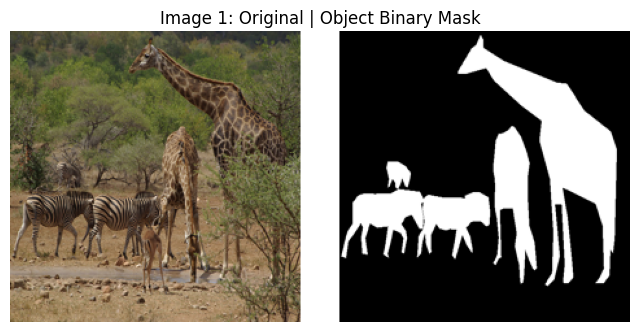

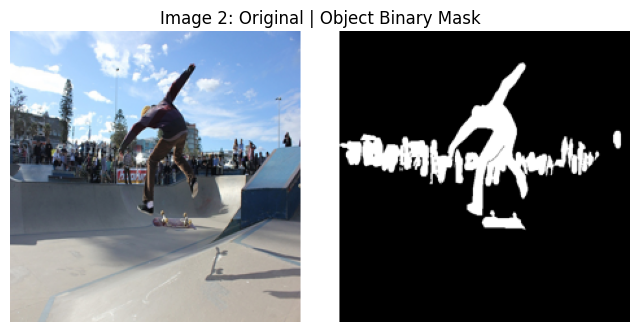

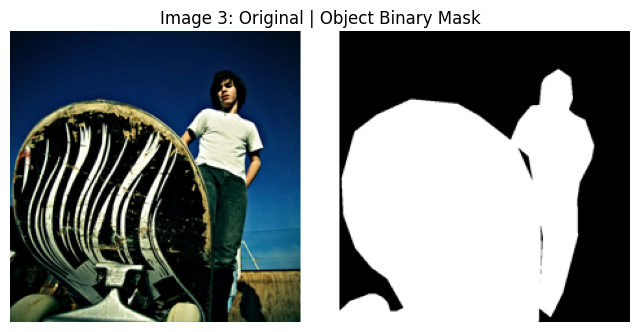

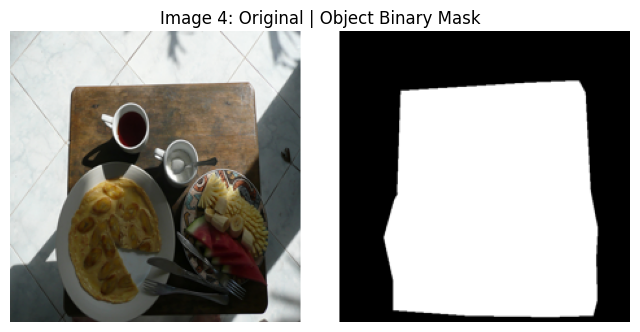

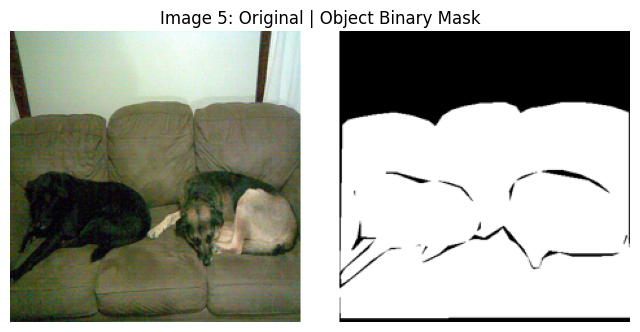

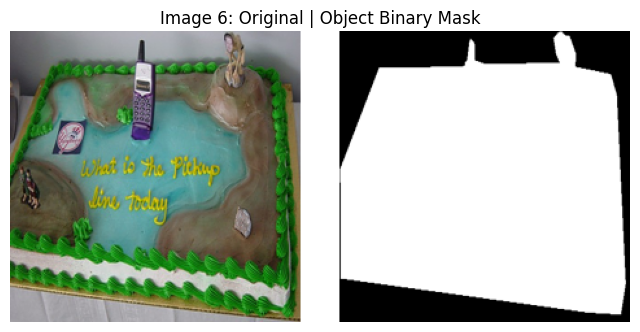

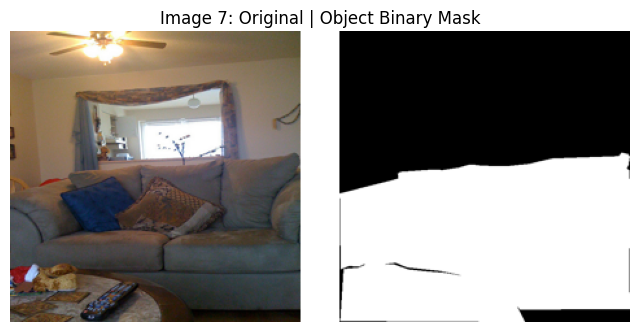

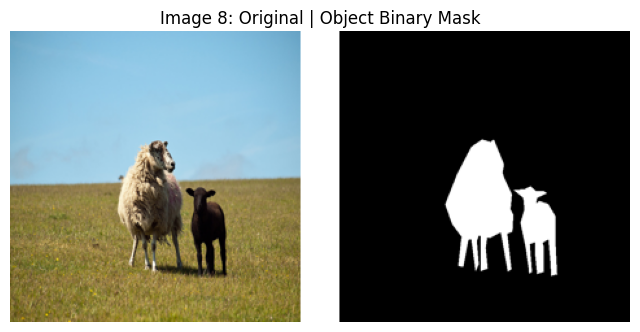

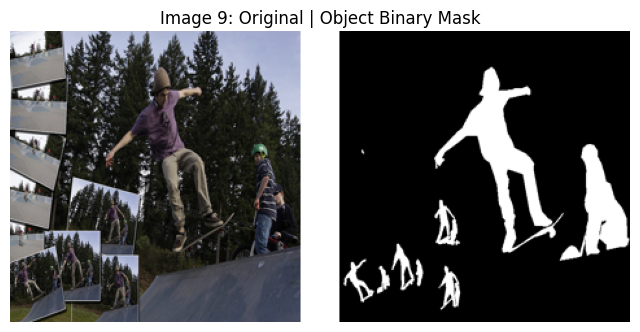

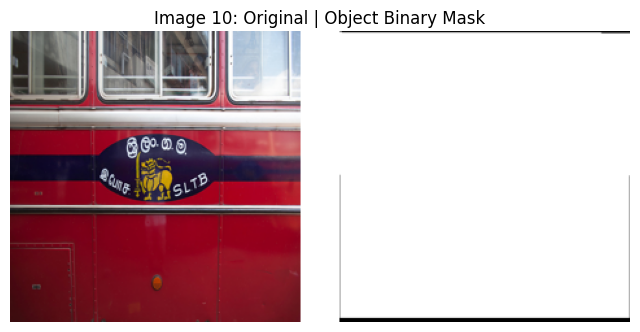

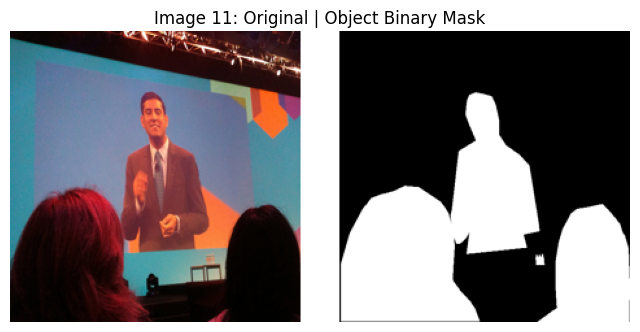

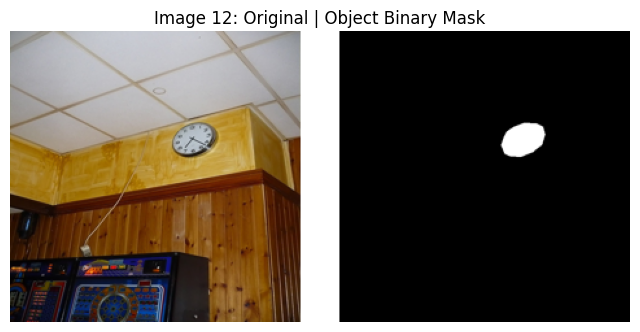

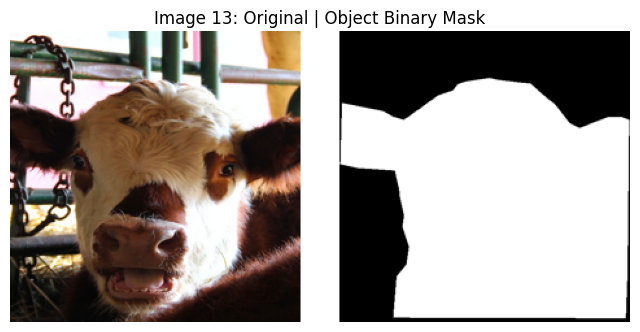

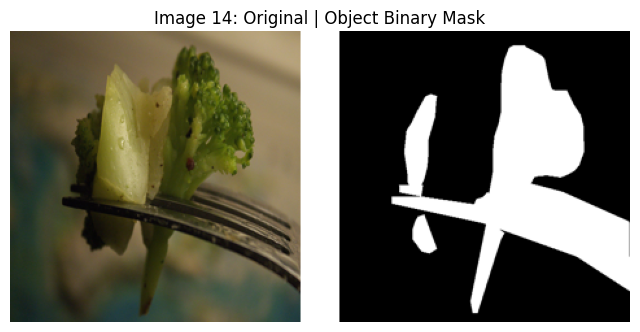

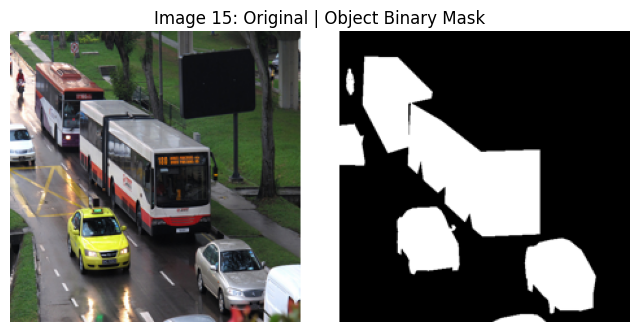

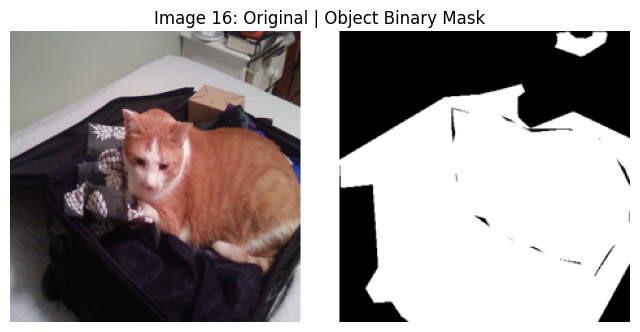

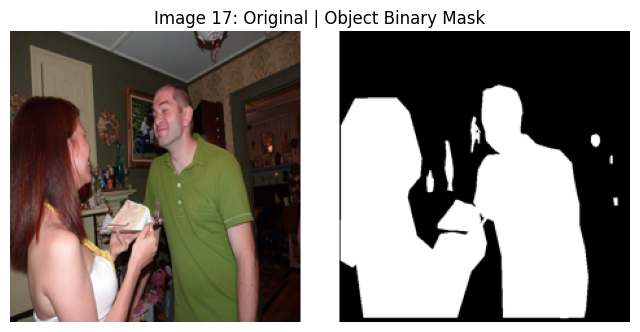

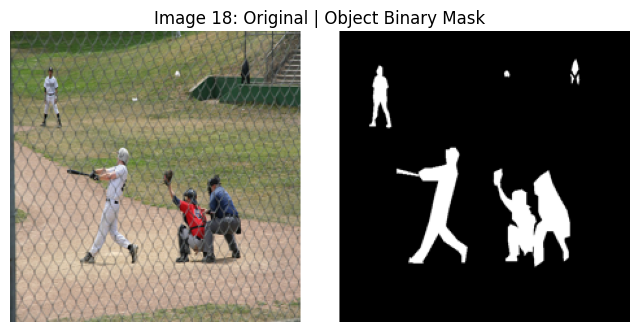

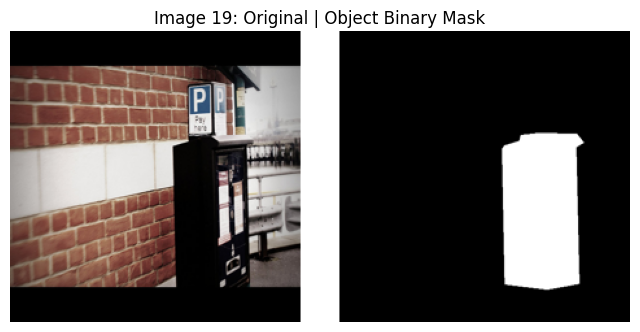

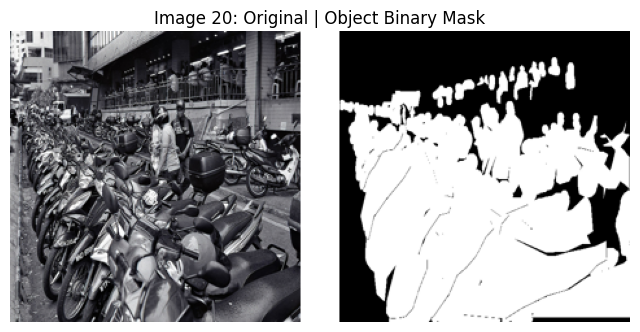

✅ Done! 20 object-only binary mask images saved in './binary_mask_output'.


In [10]:

from pycocotools.coco import COCO
import requests
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random
import os

#  Create output folder
os.makedirs('./binary_mask_output', exist_ok=True)

# Load COCO annotation file
annFile = './coco/annotations/annotations/instances_val2017.json'
coco = COCO(annFile)

# Get random 20 image IDs
img_ids = coco.getImgIds()
random_ids = random.sample(img_ids, 20)

# Generate binary masks
for i, img_id in enumerate(random_ids):
    try:
        # Load image metadata
        img_data = coco.loadImgs(img_id)[0]
        img_url = img_data['coco_url']
        img = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')
        img = img.resize((224, 224))

        # Load object annotations for that image
        ann_ids = coco.getAnnIds(imgIds=img_data['id'])
        anns = coco.loadAnns(ann_ids)

        # Build mask (object = 1, background = 0)
        mask = np.zeros((img_data['height'], img_data['width']), dtype=np.uint8)
        for ann in anns:
            mask += coco.annToMask(ann)

        # Convert mask → binary (white object, black background)
        mask = (mask > 0).astype(np.uint8) * 255
        mask = Image.fromarray(mask).resize((224, 224))

        # Save side-by-side
        combined = Image.new('RGB', (224 * 2 + 30, 224), color='white')
        combined.paste(img, (0, 0))
        combined.paste(mask.convert('RGB'), (224 + 30, 0))
        combined.save(f'./binary_mask_output/mask_{i+1}.jpg')

        # Show first 5
        if i < 20:
            plt.figure(figsize=(8, 4))
            plt.imshow(combined)
            plt.title(f"Image {i+1}: Original | Object Binary Mask")
            plt.axis('off')
            plt.show()

    except Exception as e:
        print(f"Error: {e}")
        continue

print("✅ Done! 20 object-only binary mask images saved in './binary_mask_output'.")
